## TOC
* [Model RDM](#modelrdm-bullet)
* [Plot by model](#plot_mod)
* [Plot by roi](#plot_roi)

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from nltools.mask import create_sphere

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/'
out_root = '/home/rj299/scratch60/mdm_analysis/output/'
anat_mean = nib.load(os.path.join('/home/rj299/project/mdm_analysis/output/imaging', 'all_sub_average.nii.gz'))

In [3]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

In [4]:
# all rois' names
sub = 2654
roi_rdm_obj = np.load(os.path.join(data_root, 'rdm_new/_subject_id_%s/roi_rdm.npy' %sub),
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names_all = list(roi_rdm.keys())

print('All names of ROIs:')
for roi_name in roi_names_all:
    print(roi_name)

All names of ROIs:
vmpfc
vstr
med_mon_1
med_mon_2
med_mon_3
gilaie_rppc
zhang_val_lppc
zhang_val_lofc
zhang_val_rofc
zhang_val_lingual
zhang_sal_acc
zhang_sal_lprecentral
zhang_sal_lcaudate
zhang_sal_rcaudate
zhang_sal_linsula
zhang_sal_rinsula
zhang_sal_lingual
levy_amb_striatum
levy_amb_mpfc
levy_amb_ppc
levy_amb_lamyg
levy_amb_sts
levy_risk_striatum
levy_risk_mpfc


## Model RDM <a class="anchor" id="modelrdm-bullet"></a>

In [5]:
# Load model RDMs in vectors
mod_rdm_vector_domain_obj = np.load(os.path.join(data_root, 'roi_compare_with_model/model_rdms_vector_domain.npy'),
                              allow_pickle = True)

mod_rdm_vector_domain = mod_rdm_vector_domain_obj.item()

mod_rdm_vector_domain.keys()

domain_names = list(mod_rdm_vector_domain.keys())
mod_names = list(mod_rdm_vector_domain[domain_names[0]].keys())

In [6]:
print(domain_names)
print(mod_names)

['med', 'mon']
['uncertainty_domain', 'value_domain', 'sv_domain', 'rating_domain']


In [8]:
roi_names = roi_names_all
# roi_names = ['vmpfc', 'vstr']

### Get p values from permutation test

In [10]:
stats_perm = {}

for roi_name in roi_names:

    # load data
    spearman_r = np.load(os.path.join(data_root, 'roi_compare_with_model/spearman_r_with_model_domain_%s.npy' %roi_name),
                         allow_pickle = True).item()


    # load permutation null distribution
    spearman_r_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_null_domain_%s.npy' %roi_name),
                         allow_pickle = True).item()

    mod_names = list(spearman_r.keys())
    # calculate p values for each model

    stats_perm_roi = {}

    for mod_name in mod_names:
        stats_perm_roi[mod_name] = {}
        
        for domain_name in domain_names:
            r = spearman_r[mod_name][domain_name]    
            r_null = spearman_r_perm[mod_name][domain_name]
            r_null.sort()

            r_median = np.median(r)

            # 25th-75th quantile of data
            q_25 = np.quantile(r, .25)
            q_75 = np.quantile(r, .75)

            # p value for this model (for the right tail, 1-p)
            p_mod = min(range(len(r_null)), key=lambda i: abs(r_null[i]-r_median))/len(r_null)

            # p values for right tail
            if p_mod > 0.5:
                p_mod = 1-p_mod



            # 95 interval of null distribution
            critical_95_up = r_null[int(len(r_null) * (1-0.05/2))]
            critical_95_low = r_null[int(len(r_null) * (0.05/2))]

            stats_perm_roi[mod_name][domain_name] = [r_median, q_25, q_75, p_mod, critical_95_low, critical_95_up]
    
    stats_perm[roi_name] = stats_perm_roi
    
# np.save(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), stats_perm)

In [14]:
stats_perm['vmpfc']['rating_domain']['med']

[0.21443390241873844,
 0.06853042242248342,
 0.2962282775681541,
 0.0004999999999999449,
 0.03277448602544317,
 0.12419729792042888]

In [15]:
np.save(os.path.join(data_root, 'roi_compare_with_model/perm_domain_stats.npy'), stats_perm)

In [6]:
stats_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_domain_stats.npy'), 
                     allow_pickle = True).item()

In [19]:
# Print all rois
for roi_name in stats_perm.keys():
    print(roi_name)
    
    for mod_name in stats_perm[roi_name].keys():
        for domain_name in stats_perm[roi_name][mod_name].keys():
            print(mod_name, ',', domain_name, ':', stats_perm[roi_name][mod_name][domain_name])
        
    print()    

vmpfc
uncertainty_domain , med : [-0.02680281337094487, -0.10721125348377948, 0.03573708449459316, 0.10299999999999998, -0.10283044113066209, -0.011174568990155767]
uncertainty_domain , mon : [-0.00893427112364829, -0.08934271123648291, 0.08040844011283461, 0.045499999999999985, -0.09845906724363557, 0.0]
value_domain , med : [0.250181041373571, 0.0880266627055157, 0.3243087573361105, 0.0004999999999999449, 0.0457933343534076, 0.1312785954239761]
value_domain , mon : [0.10771683725806527, -0.06254526034339275, 0.3092515650312196, 0.07099999999999995, 0.02811237588706671, 0.1205729297179974]
sv_domain , med : [0.21443390241873844, 0.06631976363466137, 0.3824439702932139, 0.0004999999999999449, 0.04982021427089859, 0.1449072743647563]
sv_domain , mon : [0.06410910484683932, -0.08842635151288183, 0.2365404902969589, 0.15449999999999997, -0.00442252856384109, 0.08695854047675346]
rating_domain , med : [0.21443390241873844, 0.06853042242248342, 0.2962282775681541, 0.0004999999999999449, 0.0

In [23]:
pd.DataFrame.from_dict(stats_perm['vmpfc']).to_csv(os.path.join(data_root, 'roi_compare_with_model/vmpfc_stats.csv'))

pd.DataFrame.from_dict(stats_perm['vstr']).to_csv(os.path.join(data_root, 'roi_compare_with_model/vstr_stats.csv'))

##  Bar plot by Model

In [20]:
roi_names

['vmpfc',
 'vstr',
 'med_mon_1',
 'med_mon_2',
 'med_mon_3',
 'gilaie_rppc',
 'zhang_val_lppc',
 'zhang_val_lofc',
 'zhang_val_rofc',
 'zhang_val_lingual',
 'zhang_sal_acc',
 'zhang_sal_lprecentral',
 'zhang_sal_lcaudate',
 'zhang_sal_rcaudate',
 'zhang_sal_linsula',
 'zhang_sal_rinsula',
 'zhang_sal_lingual',
 'levy_amb_striatum',
 'levy_amb_mpfc',
 'levy_amb_ppc',
 'levy_amb_lamyg',
 'levy_amb_sts',
 'levy_risk_striatum',
 'levy_risk_mpfc']

In [30]:
roi_names_sort = ['vstr',
#                   'levy_amb_striatum',
#                   'levy_risk_striatum',
#                   'zhang_sal_lcaudate',
#                   'zhang_sal_rcaudate',
                  'vmpfc',
#                   'levy_amb_mpfc',
#                   'levy_risk_mpfc',
                  'zhang_sal_acc',
                  'levy_amb_ppc',
                  'zhang_val_lofc',
                  'zhang_val_rofc',
                  'gilaie_rppc',
                  'zhang_val_lppc',
                  'med_mon_1',
                  'med_mon_2',
                  'med_mon_3',
                  'zhang_sal_linsula',
                  'zhang_sal_rinsula',
                  'levy_amb_lamyg',
#                   'levy_amb_sts',
#                   'zhang_sal_lprecentral',
#                   'zhang_val_lingual',                 
#                   'zhang_sal_lingual',
                 ]

roi_names_sort_leg = ['vStr',
#                   'levy_amb_striatum',
#                   'levy_risk_striatum',
#                   'zhang_sal_lcaudate',
#                   'zhang_sal_rcaudate',
                  'vmPFC',
#                   'levy_amb_mpfc',
#                   'levy_risk_mpfc',
                  'ACC',
                  'PCC',
                  'lOFC',
                  'rOFC',
                  'rPPC',
                  'lPPC',
                  'lParahippo Med>Mon',
                  'rParahippo Med>Mon',
                  'rOccipital Med>Mon',
                  'lInsula',
                  'rInsula',
                  'lAmygdala',
#                   'lSTS',
#                   'zhang_sal_lprecentral',
#                   'zhang_val_lingual',                 
#                   'zhang_sal_lingual',
                 ]

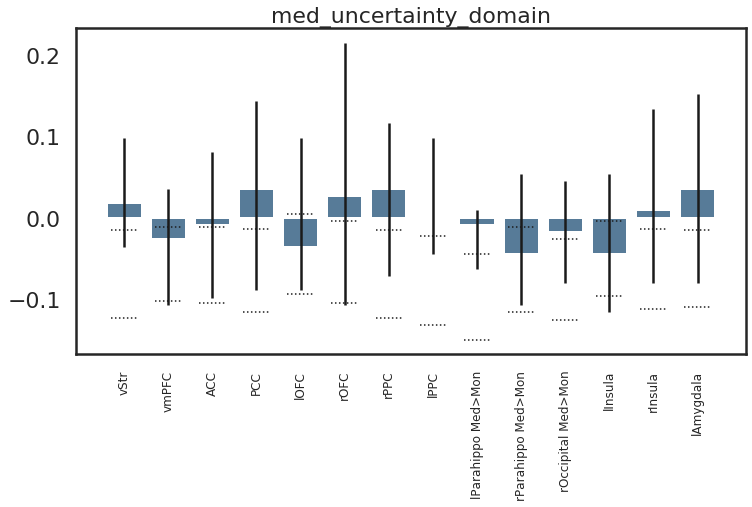

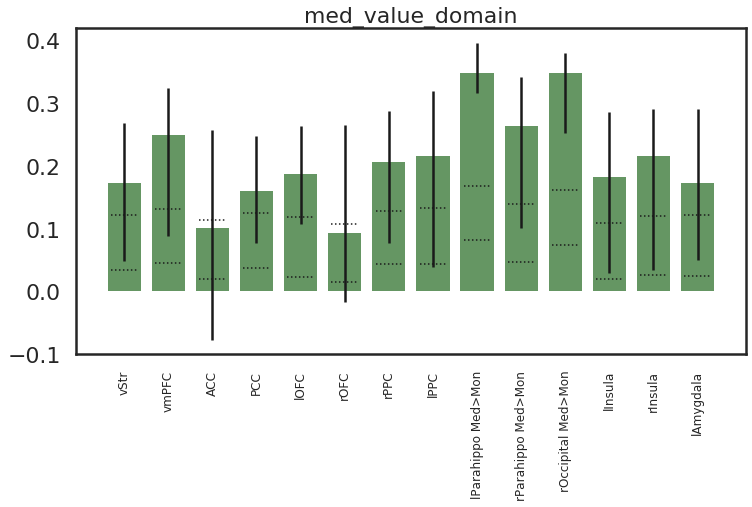

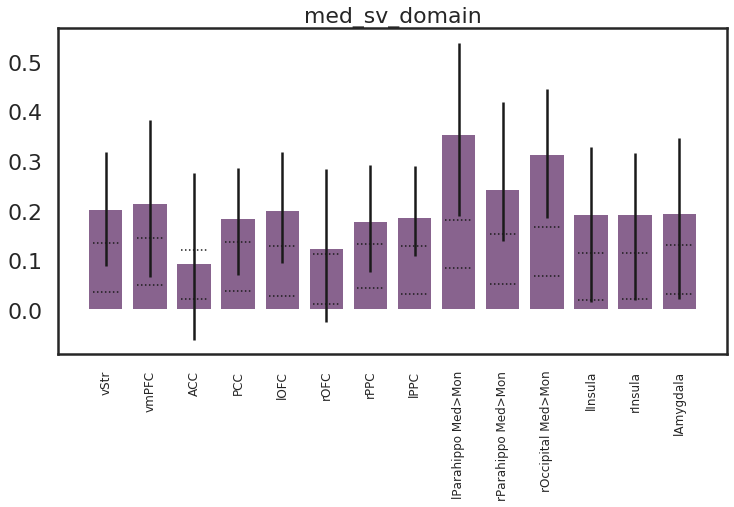

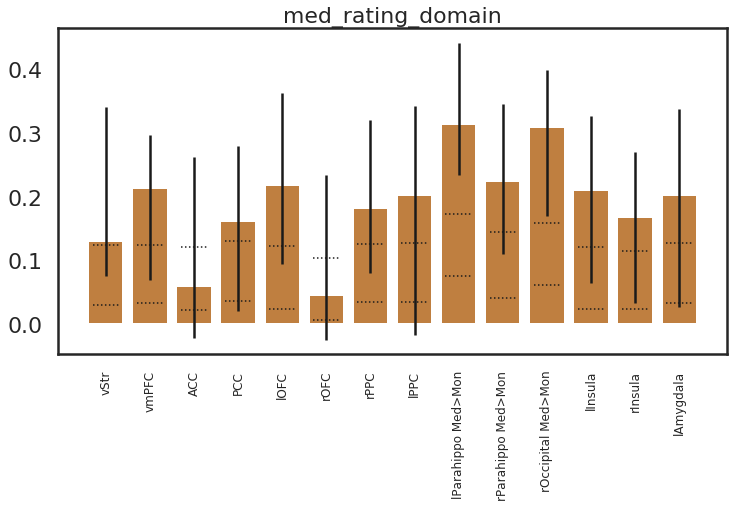

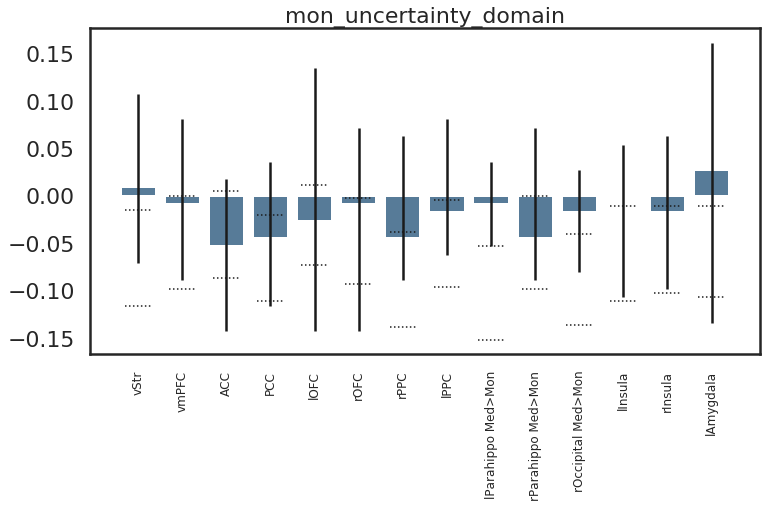

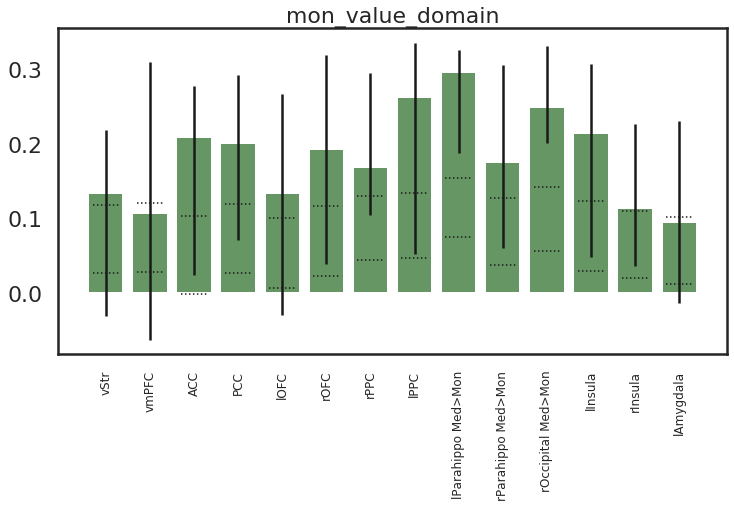

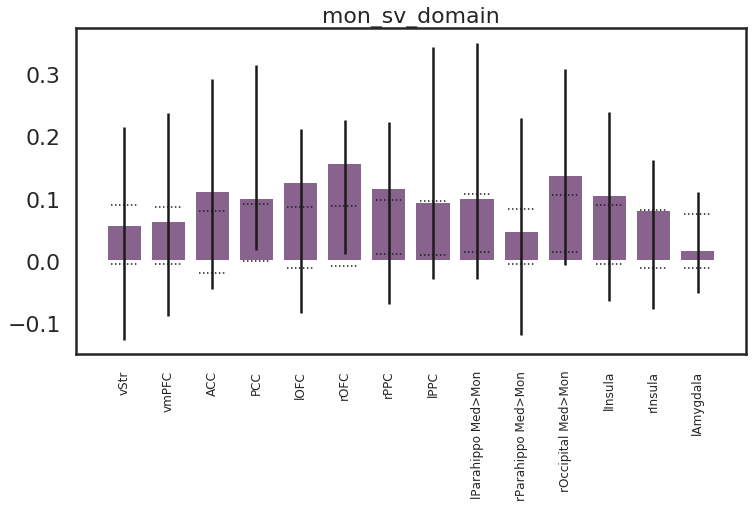

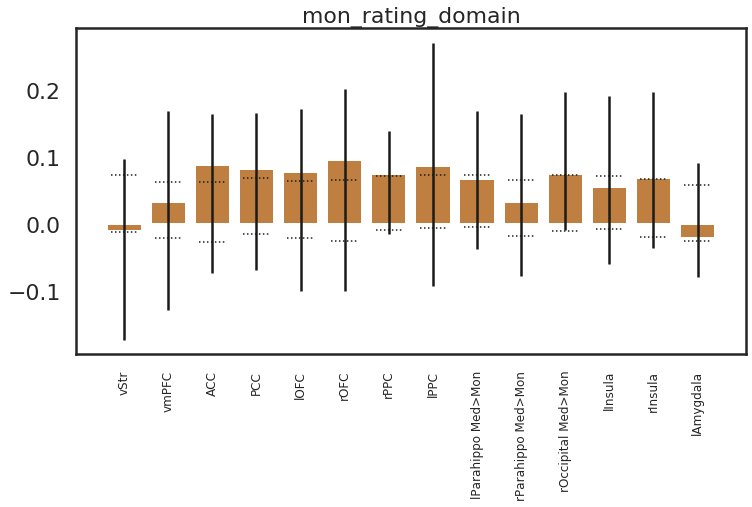

In [39]:
# stats_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), 
#                      allow_pickle = True).item()

color_mod = sns.color_palette("Set1", n_colors=5, desat=.5)

for domain_name in domain_names:
#     domain_name = 'med'
    # plot each model
    for mod_idx, mod_name in enumerate(mod_names):
        fig, ax = plt.subplots(1,1, figsize = (0.5*len(roi_names), 6))

        # length will be the number of ROIs
    #     r_plot = []
    #     eb_low = []
    #     eb_up = []
    #     p = []

        for roi_idx, roi_name in enumerate(roi_names_sort):
    #         r_plot.append(stats_perm[roi_name][mod_name][0])
    #         eb_low.append(stats_perm[roi_name][mod_name][2])
    #         eb_up.append(stats_perm[roi_name][mod_name][3])
    #         p.append(stats_perm[roi_name][mod_name][1])

            r_plot = stats_perm[roi_name][mod_name][domain_name][0]
            q_low = stats_perm[roi_name][mod_name][domain_name][1]
            q_up = stats_perm[roi_name][mod_name][domain_name][2]
            eb_low = stats_perm[roi_name][mod_name][domain_name][4]
            eb_up = stats_perm[roi_name][mod_name][domain_name][5]
            p = stats_perm[roi_name][mod_name][domain_name][3]

            ax.bar(roi_idx, r_plot, 
                   yerr = np.array([r_plot-q_low, q_up-r_plot]).reshape(2,1), 
                   color = color_mod[mod_idx+1])

            ax.hlines(eb_up, xmin = roi_idx-0.3, xmax = roi_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
            ax.hlines(eb_low, xmin = roi_idx-0.3, xmax = roi_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
    #         ax.annotate(round(p, 4), (roi_idx-0.3, r_plot), fontsize = 9)

        ax.set_xticks(list(range(len(roi_names_sort))))
        ax.set_xticklabels(roi_names_sort_leg, fontsize = 12, rotation = 90)

    #     ax.legend(roi_names_sort_leg, fontsize = 9, loc = 'right', bbox_to_anchor=(1.2, .5))
        ax.set_title(domain_name+'_'+mod_name, fontsize = 22)

        fig.savefig(os.path.join(out_root,"imaging","Sink_resp_rsa_nosmooth", "roi_compare_with_model", 
                                 "roi_rsa_%s_%s.eps" %(domain_name, mod_name)), format = 'eps')

### Correct for multiple comparisons

In [28]:
import statsmodels.stats as sm_stats

In [33]:
roi_names_sort = ['vstr',
#                   'levy_amb_striatum',
#                   'levy_risk_striatum',
#                   'zhang_sal_lcaudate',
#                   'zhang_sal_rcaudate',
                  'vmpfc',
#                   'levy_amb_mpfc',
#                   'levy_risk_mpfc',
                  'zhang_sal_acc',
                  'levy_amb_ppc',
                  'zhang_val_lofc',
                  'zhang_val_rofc',
                  'gilaie_rppc',
                  'zhang_val_lppc',
                  'med_mon_1',
                  'med_mon_2',
                  'med_mon_3',
                  'zhang_sal_linsula',
                  'zhang_sal_rinsula',
                  'levy_amb_lamyg',
#                   'levy_amb_sts',
#                   'zhang_sal_lprecentral',
#                   'zhang_val_lingual',                 
#                   'zhang_sal_lingual',
                 ]


In [35]:
# plot each model
for domain_name in domain_names:
    for mod_idx, mod_name in enumerate(mod_names):
        p = []
        for roi_idx, roi_name in enumerate(roi_names_sort):
            p.append(stats_perm[roi_name][mod_name][domain_name][3])


        print(domain_name+'_'+mod_name)
        print(p)
        print()
        p_adjust = sm_stats.multitest.multipletests(p, alpha = 0.5, method = 'fdr_bh')
        print(p_adjust[1])
        print()

med_uncertainty_domain
[0.0004999999999999449, 0.10299999999999998, 0.019499999999999962, 0.0004999999999999449, 0.35050000000000003, 0.0020000000000000018, 0.0004999999999999449, 0.0030000000000000027, 0.0004999999999999449, 0.25049999999999994, 0.008499999999999952, 0.39849999999999997, 0.0010000000000000009, 0.0004999999999999449]

[0.0014     0.13109091 0.0273     0.0014     0.37746154 0.004
 0.0014     0.00525    0.0014     0.29225    0.01322222 0.3985
 0.00233333 0.0014    ]

med_value_domain
[0.0004999999999999449, 0.0004999999999999449, 0.0595, 0.0004999999999999449, 0.0004999999999999449, 0.06499999999999995, 0.0004999999999999449, 0.0004999999999999449, 0.0004999999999999449, 0.0004999999999999449, 0.0004999999999999449, 0.0004999999999999449, 0.0004999999999999449, 0.0004999999999999449]

[0.00058333 0.00058333 0.06407692 0.00058333 0.00058333 0.065
 0.00058333 0.00058333 0.00058333 0.00058333 0.00058333 0.00058333
 0.00058333 0.00058333]

med_sv_domain
[0.000499999999999944

### Plot ROIs

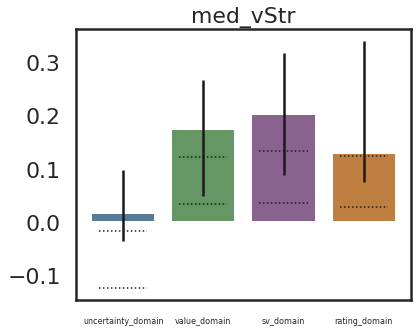

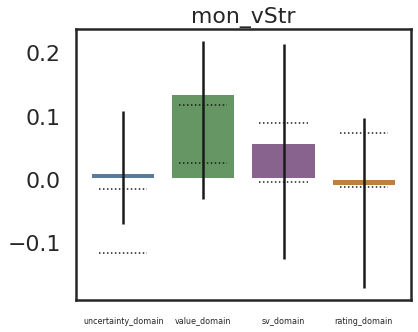

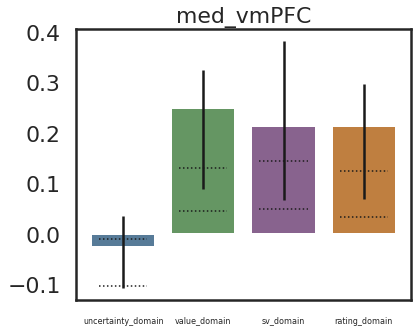

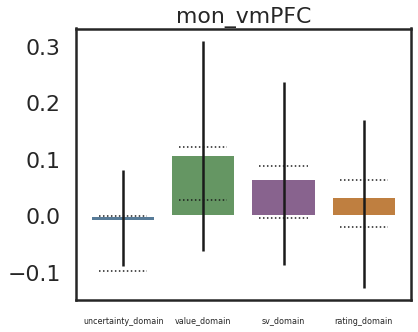

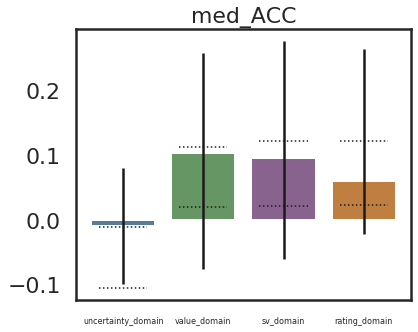

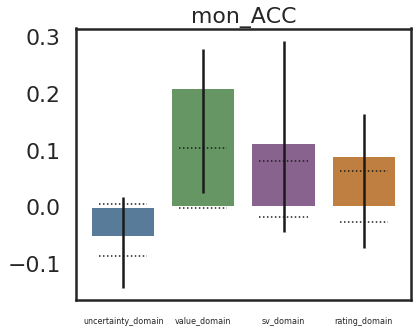

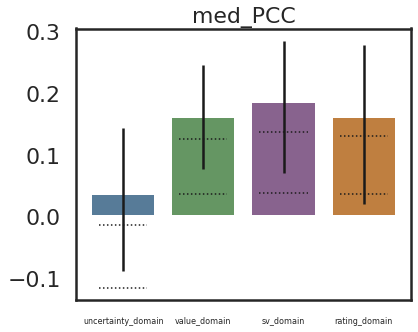

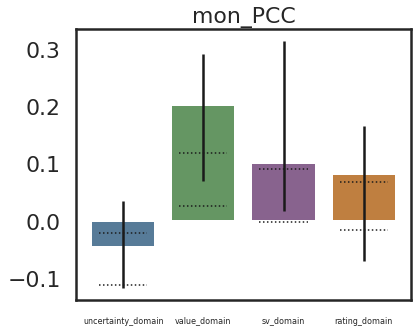

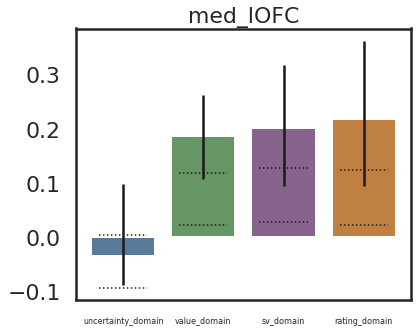

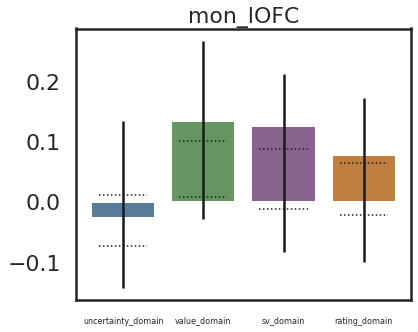

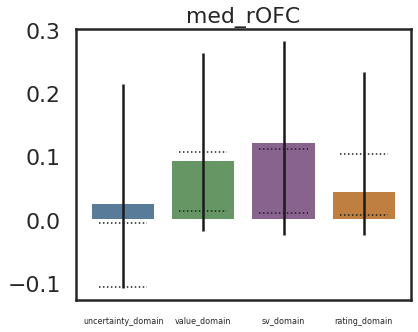

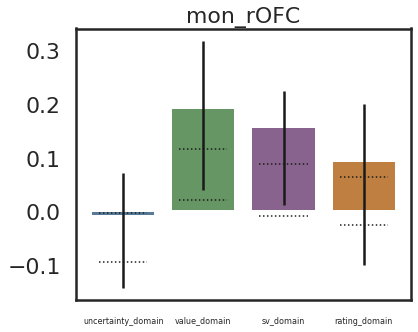

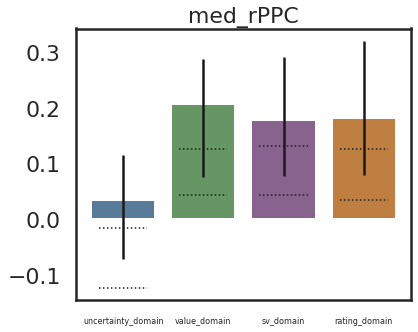

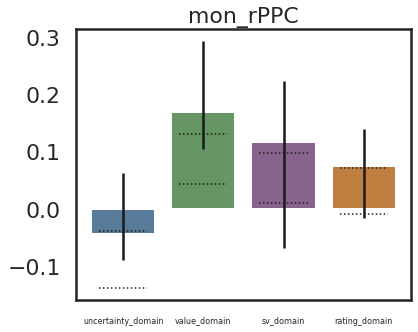

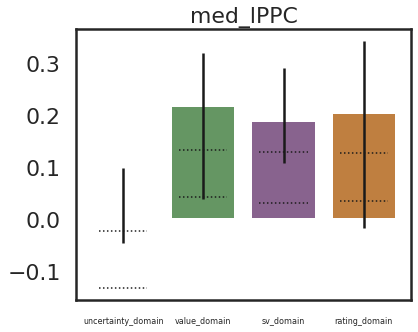

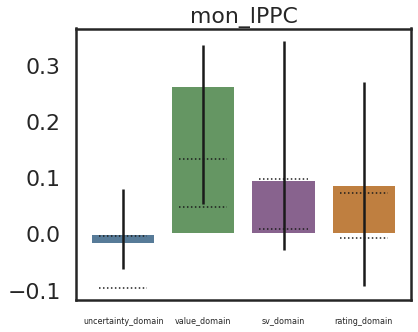

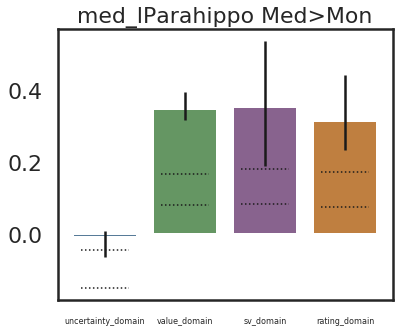

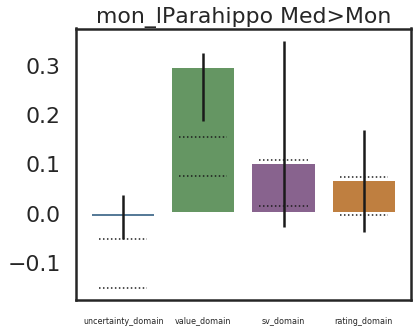

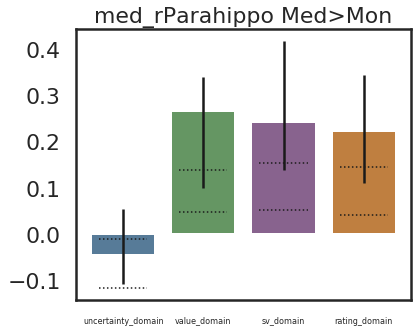

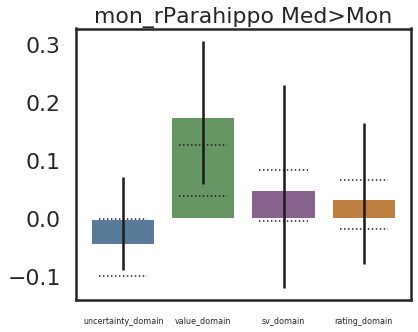

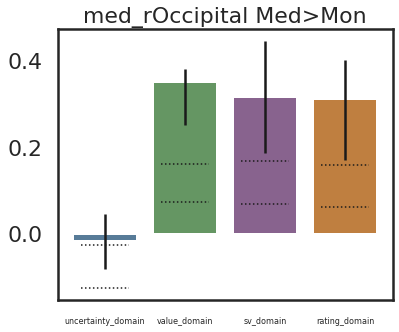

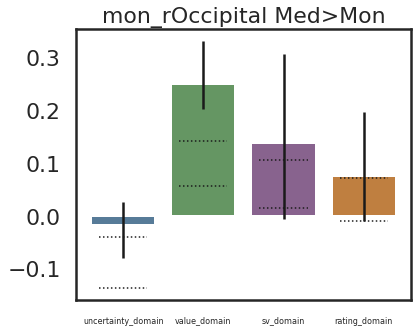

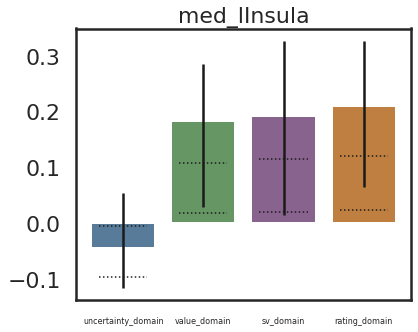

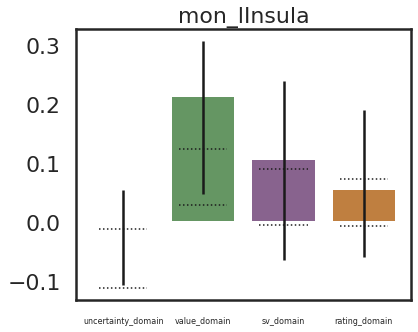

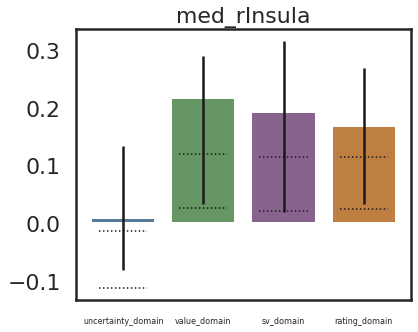

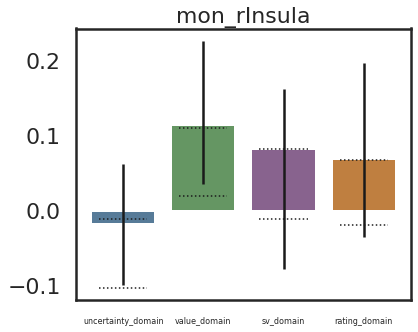

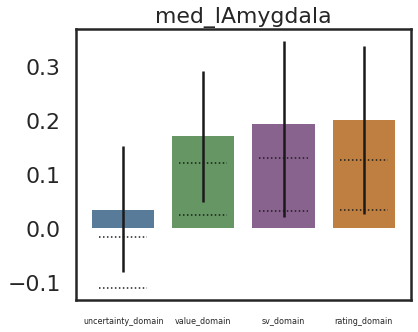

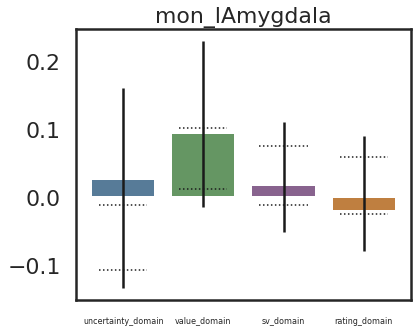

In [38]:
# stats_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), 
#                      allow_pickle = True).item()

color_mod = sns.color_palette("Set1", n_colors=5, desat=.5)
    
# plot each model
for roi_idx, roi_name in enumerate(roi_names_sort):
    for domain_name in domain_names:
        fig, ax = plt.subplots(1,1, figsize = (6, 5))

        # length will be the number of ROIs
    #     r_plot = []
    #     eb_low = []
    #     eb_up = []
    #     p = []

        for mod_idx, mod_name in enumerate(mod_names):
    #         r_plot.append(stats_perm[roi_name][mod_name][0])
    #         eb_low.append(stats_perm[roi_name][mod_name][2])
    #         eb_up.append(stats_perm[roi_name][mod_name][3])
    #         p.append(stats_perm[roi_name][mod_name][1])

            r_plot = stats_perm[roi_name][mod_name][domain_name][0]
            q_low = stats_perm[roi_name][mod_name][domain_name][1]
            q_up = stats_perm[roi_name][mod_name][domain_name][2]
            eb_low = stats_perm[roi_name][mod_name][domain_name][4]
            eb_up = stats_perm[roi_name][mod_name][domain_name][5]
            p = stats_perm[roi_name][mod_name][domain_name][3]

            ax.bar(mod_idx, r_plot, 
                   yerr = np.array([r_plot-q_low, q_up-r_plot]).reshape(2,1),
                   color = color_mod[mod_idx+1]) # for different color

            ax.hlines(eb_up, xmin = mod_idx-0.3, xmax = mod_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
            ax.hlines(eb_low, xmin = mod_idx-0.3, xmax = mod_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
    #         ax.annotate(round(p, 4), (mod_idx-0.3, r_plot), fontsize = 12)

        ax.set_xticks(list(range(len(mod_names))))
        ax.set_xticklabels(mod_names, fontsize = 8, rotation = 0)

    #     ax.legend(roi_names_sort_leg, fontsize = 9, loc = 'right', bbox_to_anchor=(1.2, .5))
    #     if roi_name == 'levy_amb_ppc':
    #         roi_name = 'levy_amb_pcc'
        ax.set_title(domain_name+'_'+roi_names_sort_leg[roi_idx], fontsize = 22) 

        fig.savefig(os.path.join(out_root,"imaging","Sink_resp_rsa_nosmooth", "roi_compare_with_model", 
                                 "roi_rsa_%s_%s.eps" %(domain_name, roi_names_sort_leg[roi_idx])), format = 'eps')

### Compare models, in vStr and vmPFC

In [7]:
import scikit_posthocs as sp

In [8]:
roi_name = 'vmpfc'
spearman_r = np.load(os.path.join(data_root, 'roi_compare_with_model/spearman_r_with_model_%s.npy' %roi_name),
                         allow_pickle = True).item()

In [9]:
spearman_r.keys()

dict_keys(['domain', 'uncertainty', 'value', 'sv', 'rating'])

In [10]:
spearman_r_valuemod = []
for key_name in ['value', 'sv', 'rating']:
    spearman_r_valuemod.append(spearman_r[key_name])

In [11]:
# non parametric repeated measure anova
test_stat, p = stats.friedmanchisquare(spearman_r['value'], spearman_r['sv'], spearman_r['rating'])
print(test_stat)
print(p)

1.5151515151515014
0.4688015391402386


In [48]:
# post_hoc
sp.posthoc_wilcoxon(spearman_r_valuemod, p_adjust = 'fdr_bh')

,1,2,3
1,-1.000000,0.57925,0.837197
2,0.579250,-1.00000,0.579250
3,0.837197,0.57925,-1.000000


In [50]:
stats.wilcoxon(spearman_r['sv'], spearman_r['value'])

WilcoxonResult(statistic=209.0, pvalue=0.20140821617026083)

In [ ]:
# stats_perm = {}


# for roi_name in ['vmpfc', 'vstr']:

#     # load data
#     spearman_r = np.load(os.path.join(data_root, 'roi_compare_with_model/spearman_r_with_model_%s.npy' %roi_name),
#                          allow_pickle = True).item()


#     # load permutation null distribution
#     spearman_r_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_null_%s.npy' %roi_name),
#                          allow_pickle = True).item()

#     mod_names = list(spearman_r.keys())
#     # calculate p values for each model

#     stats_perm_roi = {}
